In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import json
import pickle

from tensorflow import keras
from keras import models, layers
from keras.models import load_model

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from qiskit.visualization import plot_histogram 
import seaborn as sns


In [5]:
def NN_model(n_qubit, n_hidden_layer = 4, n_nodes = 5, activation = 'relu', d = 0.0):
    model = models.Sequential()
    model.add(layers.Dense(n_nodes * (2 ** n_qubit), activation = activation, kernel_initializer= keras.initializers.lecun_normal, input_shape = (2 ** n_qubit, )))

    for i in range(n_hidden_layer):
        model.add(layers.Dense(n_nodes * (2 ** n_qubit), activation = activation, kernel_initializer= keras.initializers.lecun_normal))
        #model.add(layers.Dropout(d))
            
    model.add(layers.Dense(2 ** n_qubit, activation = 'softmax'))
    
    return model

def loss_function(p_ideal, p_mitigated, n_qubit):
    MSE = 0
    for i in range(len(p_mitigated)):
        x = 0
        for j in range(2**n_qubit):
             x += (abs(p_mitigated[i][j] - p_ideal[i][j]) ** 2)
        x /= 2**n_qubit
        MSE += x
    MSE /= len(p_mitigated)

    KLD = 0
    for i in range(len(p_mitigated)):
        x = 0
        for j in range(2**n_qubit):
            if p_ideal[i][j] < 1e-15 or p_mitigated[i][j] < 1e-15:
                x += 0
            else:
                x += p_ideal[i][j] * (math.log(p_ideal[i][j]) - math.log(p_mitigated[i][j]))
        KLD += x
    KLD /= len(p_mitigated)
    
    IF = 0
    for i in range(len(p_mitigated)):
        x = 0
        for j in range(2**n_qubit):
            x += math.sqrt(p_ideal[i][j] * p_mitigated[i][j])
        IF += (1 - x**2)
    IF /= len(p_mitigated)

    return MSE, KLD, IF


In [6]:

def get_train_test(x, y, mit, n_data, random_state = 0):
    train_x = x.sample(n_data, random_state = random_state)
    test_x = x.drop(train_x.index)

    train_y = y.sample(n_data, random_state = random_state)
    test_y = y.drop(train_y.index)

    train_miti= mit.sample(n_data, random_state = random_state)
    test_miti = mit.drop(train_miti.index)

    train_x.reset_index(drop = True, inplace = True)
    test_x.reset_index(drop = True, inplace = True)
    train_y.reset_index(drop = True, inplace = True)
    test_y.reset_index(drop = True, inplace = True)
    train_miti.reset_index(drop = True, inplace = True)
    test_miti.reset_index(drop = True, inplace = True)

    return train_x, test_x, train_y, test_y, train_miti, test_miti

def create_x(t, w, n, d):
    return [t * x + w * n for x in range(d)]

def show_plot(topics, unmitigated, LI, NN, type = 0, label = ['unmitigated', 'LI', 'NN']):
    n = 1  # This is our first dataset (out of 2)
    t = 3 # Number of dataset
    d = 1 # Number of sets of bars
    w = 0.8 # Width of each bar

    value_a_x = create_x(t, w, 1, d)
    value_b_x = create_x(t, w, 2, d)
    value_c_x = create_x(t, w, 3, d)

    ax = plt.subplot()
    x_1 = [unmitigated[0][type]]
    x_2 = [LI[0][type]]
    x_3 = [NN[0][type]]
    ax.bar(value_a_x, x_1, label = label[0], color = 'black')
    ax.bar(value_b_x, x_2, label = label[1], color = 'white', edgecolor = 'black')
    ax.bar(value_c_x, x_3, label = label[2], color = 'white', edgecolor = 'black', hatch = '/////')

    #middle_x = [a for (a) in zip(value_a_x)]
    ax.set_xticks(value_b_x)
    ax.set_xticklabels(topics)
    plt.legend()

    img_name = ''
    if type == 0:
        plt.xlabel('(a) MSE')
        img_name = 'MSE'
    elif type == 1:
        plt.xlabel('(b) KLD')
        img_name = 'KLD'
    else:
        plt.xlabel('(c) IF')
        img_name = 'IF'

    plt.savefig('./img/'+ img_name +'.png')

    plt.show()


In [13]:
def make_mean_std(res, size):
    t = [[] for i in range(size)]

    for i in res:
        for j in range(size):
            t[j].append(i[j][2])

    mean_res = []
    std_res = []    
    for i in t:
        mean_res.append(np.mean(i))
        std_res.append(np.std(i))
        
    return mean_res, std_res
        

In [86]:
n_qubits = [5]
n_data = 300 
times = [15]
device_type = "ibm_geneva"
number = 0

#n_qubits = [5]
#n_data = 900 
#times = [5]
#device_type = 'ibmq_toronto'
#number = 0

In [87]:
X = pd.read_csv(device_type + '_' + str(n_qubits[0]) +  'qubits_obs_' + str(number) + '.csv')
Y = pd.read_csv(device_type + '_' + str(n_qubits[0]) +  'qubits_ideal_' + str(number) + '.csv')
LI = pd.read_csv(device_type + '_' + str(n_qubits[0]) +  'qubits_miti_' + str(number) + '.csv')

In [88]:
n_train_data = 4000
random_state = [56, 1, 14, 44, 71]
train_size = [50, 100, 500, 1000, 2000, 3000, 4000]

unmitigated_res = []
LI_res = []
NN_res = []
    
for i in random_state:
    trainX, testX, trainY, testY, train_LI_miti, test_LI_miti = get_train_test(X, Y, LI, n_train_data, random_state = i)
    
    unmitigated_p = []
    LI_res_p = []
    NN_res_p = []
    
    for j in train_size:
        miti = []

        model = NN_model(n_qubit = 5, n_hidden_layer = 2, n_nodes = 3, activation = 'selu')
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate = 0.0001,
            decay_steps = 100000,
            decay_rate = 0.96)
        adam = keras.optimizers.Adam(learning_rate = lr_schedule)
        model.compile(loss='categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
        model.fit(trainX[ : j], trainY[ : j], epochs = 300, batch_size = 16)

        miti.append(model.predict(testX))    

        unmitigated_p.append(loss_function(testY.values, testX.values, n_qubits[0]))
        LI_res_p.append(loss_function(testY.values, test_LI_miti.values, n_qubits[0]))
        NN_res_p.append(loss_function(testY.values, miti[0], n_qubits[0]))
        
    unmitigated_res.append(unmitigated_p)
    LI_res.append(LI_res_p)
    NN_res.append(NN_res_p)
        

Epoch 1/300
4/4 [==============================] - 0s 1ms/step - loss: 3.4625 - accuracy: 0.1000
Epoch 2/300
4/4 [==============================] - 0s 997us/step - loss: 3.4528 - accuracy: 0.1000
Epoch 3/300
4/4 [==============================] - 0s 997us/step - loss: 3.4452 - accuracy: 0.1200
Epoch 4/300
4/4 [==============================] - 0s 997us/step - loss: 3.4373 - accuracy: 0.1400
Epoch 5/300
4/4 [==============================] - 0s 1ms/step - loss: 3.4295 - accuracy: 0.1400
Epoch 6/300
4/4 [==============================] - 0s 4ms/step - loss: 3.4215 - accuracy: 0.1400
Epoch 7/300
4/4 [==============================] - 0s 2ms/step - loss: 3.4140 - accuracy: 0.1400
Epoch 8/300
4/4 [==============================] - 0s 2ms/step - loss: 3.4069 - accuracy: 0.1600
Epoch 9/300
4/4 [==============================] - 0s 665us/step - loss: 3.3997 - accuracy: 0.1800
Epoch 10/300
4/4 [==============================] - 0s 998us/step - loss: 3.3923 - accuracy: 0.1600
Epoch 11/300
4/4 [=

In [89]:
unmitigated_res_1 = []
LI_res_1 = []
NN_res_1 = []
    
for i in random_state:
    trainX, testX, trainY, testY, train_LI_miti, test_LI_miti = get_train_test(X, Y, LI, n_train_data, random_state = i)
    
    unmitigated_p = []
    LI_res_p = []
    NN_res_p = []
    
    for j in train_size:
        miti = []

        model = NN_model(n_qubit = 5, n_hidden_layer = 2, n_nodes = 3, activation = 'selu')
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate = 0.0001,
            decay_steps = 100000,
            decay_rate = 0.96)
        adam = keras.optimizers.Adam(learning_rate = lr_schedule)
        model.compile(loss='categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
        model.fit(trainX[ : j], trainY[ : j], epochs = 300, batch_size = 1)

        miti.append(model.predict(testX))    

        unmitigated_p.append(loss_function(testY.values, testX.values, n_qubits[0]))
        LI_res_p.append(loss_function(testY.values, test_LI_miti.values, n_qubits[0]))
        NN_res_p.append(loss_function(testY.values, miti[0], n_qubits[0]))
        
    unmitigated_res_1.append(unmitigated_p)
    LI_res_1.append(LI_res_p)
    NN_res_1.append(NN_res_p)
        

Epoch 1/300
50/50 [==============================] - 0s 651us/step - loss: 3.4827 - accuracy: 0.0200
Epoch 2/300
50/50 [==============================] - 0s 549us/step - loss: 3.4408 - accuracy: 0.0600
Epoch 3/300
50/50 [==============================] - 0s 478us/step - loss: 3.4006 - accuracy: 0.1800
Epoch 4/300
50/50 [==============================] - 0s 509us/step - loss: 3.3626 - accuracy: 0.2600
Epoch 5/300
50/50 [==============================] - 0s 529us/step - loss: 3.3253 - accuracy: 0.3400
Epoch 6/300
50/50 [==============================] - 0s 468us/step - loss: 3.2889 - accuracy: 0.4000
Epoch 7/300
50/50 [==============================] - 0s 488us/step - loss: 3.2490 - accuracy: 0.5000
Epoch 8/300
50/50 [==============================] - 0s 468us/step - loss: 3.2105 - accuracy: 0.5200
Epoch 9/300
50/50 [==============================] - 0s 488us/step - loss: 3.1707 - accuracy: 0.5200
Epoch 10/300
50/50 [==============================] - 0s 478us/step - loss: 3.1318 - accura

In [91]:
mean_unmiti, std_unmiti = make_mean_std(unmitigated_res, len(train_size))
mean_LI, std_LI = make_mean_std(LI_res, len(train_size))
mean_NN, std_NN = make_mean_std(NN_res, len(train_size))
mean_NN_1, std_NN_1 = make_mean_std(NN_res_1, len(train_size))


In [92]:
print("unmitigated_res mean : ", mean_unmiti, ' std : ', std_unmiti)
print("LI_res mean : ", mean_LI, ' std : ', std_LI)
print("NN_res mean : ", mean_NN, ' std : ', std_NN)
print("NN_res_1 mean : ", mean_NN_1, ' std : ', std_NN_1)


unmitigated_res mean :  [0.013133616640526652, 0.013133616640526652, 0.013133616640526652, 0.013133616640526652, 0.013133616640526652, 0.013133616640526652, 0.013133616640526652]  std :  [0.0005592838475052808, 0.0005592838475052808, 0.0005592838475052808, 0.0005592838475052808, 0.0005592838475052808, 0.0005592838475052808, 0.0005592838475052808]
LI_res mean :  [0.013958654715502932, 0.013958654715502932, 0.013958654715502932, 0.013958654715502932, 0.013958654715502932, 0.013958654715502932, 0.013958654715502932]  std :  [0.00027093632036660255, 0.00027093632036660255, 0.00027093632036660255, 0.00027093632036660255, 0.00027093632036660255, 0.00027093632036660255, 0.00027093632036660255]
NN_res mean :  [0.050755073385170005, 0.02819033880432607, 0.016579575042221434, 0.012404370664267975, 0.008607585123979635, 0.006730748675000932, 0.005983150190471347]  std :  [0.007737811664755506, 0.0012285994261599844, 0.0006361570120740855, 0.0004549938429737303, 0.00023132575311010862, 0.000346973

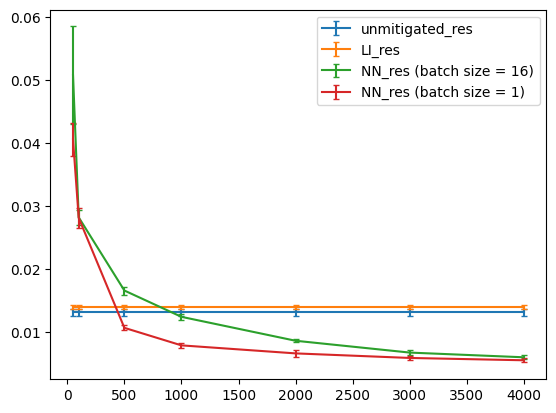

In [93]:
plt.errorbar(train_size, mean_unmiti, yerr = std_unmiti, capsize = 2, label = 'unmitigated_res')
plt.errorbar(train_size, mean_LI, yerr = std_LI, capsize = 2, label = 'LI_res')
plt.errorbar(train_size, mean_NN, yerr = std_NN, capsize = 2, label = 'NN_res (batch size = 16)')
plt.errorbar(train_size, mean_NN_1, yerr = std_NN_1, capsize = 2, label = 'NN_res (batch size = 1)')
plt.legend()

# transfer learning

In [7]:
#n_qubits = [5]
#n_data = 300 
#times = [15]
#device_type = "ibm_geneva"
#number = 0

n_qubits = [5]
n_data = 900 
times = [5]
device_type = 'ibmq_toronto'
number = 1

# 아래는 학습한 device
another_device_type = "ibmq_toronto"

In [8]:
X = pd.read_csv(device_type + '_' + str(n_qubits[0]) +  'qubits_obs_' + str(number) + '.csv')
Y = pd.read_csv(device_type + '_' + str(n_qubits[0]) +  'qubits_ideal_' + str(number) + '.csv')
LI = pd.read_csv(device_type + '_' + str(n_qubits[0]) +  'qubits_miti_' + str(number) + '.csv')

In [17]:
n_train_data = 4000
random_state = [56, 1, 14, 44, 71]
train_size = [50, 100, 500, 1000, 2000, 3000, 4000]

unmitigated_res = []
NN_res = []
NN_transfer_res = []

for i in random_state:
    trainX, testX, trainY, testY, train_LI_miti, test_LI_miti = get_train_test(X, Y, LI, n_train_data, random_state = i)
    
    unmitigated_p = []
    NN_res_p = []
    NN_transfer_res_p = []
    
    for j in train_size:
        
        f = another_device_type + '_' + str(n_qubits[0]) + 'qubits_model.h5'
        
        miti_t1 = []
        
        model_t1 = load_model(f)
        for layer in model_t1.layers:
            layer.trainable = False

        model_t1.layers[3].trainable = True

        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate = 0.0001,
            decay_steps = 100000,
            decay_rate = 0.96)
        adam = keras.optimizers.Adam(learning_rate = lr_schedule)
        model_t1.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
        history_1 = model_t1.fit(trainX[ : j], trainY[ : j], epochs = 300, batch_size = 1)

        miti_t1.append(model_t1.predict(testX))           
                
        
        miti_t2 = []

        model_t2 = NN_model(n_qubit = 5, n_hidden_layer = 2, n_nodes = 3, activation = 'selu')
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate = 0.0001,
            decay_steps = 100000,
            decay_rate = 0.96)
        adam = keras.optimizers.Adam(learning_rate = lr_schedule)
        model_t2.compile(loss='categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
        model_t2.fit(trainX[ : j], trainY[ : j], epochs = 300, batch_size = 1)

        miti_t2.append(model_t2.predict(testX))    

        unmitigated_p.append(loss_function(testY.values, testX.values, n_qubits[0]))
        NN_res_p.append(loss_function(testY.values, miti_t2[0], n_qubits[0]))
        NN_transfer_res_p.append(loss_function(testY.values, miti_t1[0], n_qubits[0]))
        
        
    unmitigated_res.append(unmitigated_p)
    NN_res.append(NN_res_p)
    NN_transfer_res.append(NN_transfer_res_p)


Epoch 1/300
50/50 [==============================] - 0s 473us/step - loss: 3.0928 - accuracy: 0.1400
Epoch 2/300
50/50 [==============================] - 0s 469us/step - loss: 3.0259 - accuracy: 0.1400
Epoch 3/300
50/50 [==============================] - 0s 436us/step - loss: 2.9719 - accuracy: 0.2000
Epoch 4/300
50/50 [==============================] - 0s 444us/step - loss: 2.9275 - accuracy: 0.2400
Epoch 5/300
50/50 [==============================] - 0s 428us/step - loss: 2.8904 - accuracy: 0.3000
Epoch 6/300
50/50 [==============================] - 0s 428us/step - loss: 2.8606 - accuracy: 0.3600
Epoch 7/300
50/50 [==============================] - 0s 450us/step - loss: 2.8362 - accuracy: 0.4200
Epoch 8/300
50/50 [==============================] - 0s 422us/step - loss: 2.8161 - accuracy: 0.4200
Epoch 9/300
50/50 [==============================] - 0s 424us/step - loss: 2.7999 - accuracy: 0.4200
Epoch 10/300
50/50 [==============================] - 0s 429us/step - loss: 2.7872 - accura

In [18]:
mean_unmiti, std_unmiti = make_mean_std(unmitigated_res, len(train_size))
mean_NN, std_NN = make_mean_std(NN_res, len(train_size))
mean_NN_transfer, std_NN_transfer = make_mean_std(NN_transfer_res, len(train_size))

In [19]:
print("unmitigated_res mean : ", mean_unmiti, ' std : ', std_unmiti)
print("NN_res mean : ", mean_NN, ' std : ', std_NN)
print("NN_res_1 mean : ", mean_NN_transfer, ' std : ', std_NN_transfer)


unmitigated_res mean :  [0.2800426715720352, 0.2800426715720352, 0.2800426715720352, 0.2800426715720352, 0.2800426715720352, 0.2800426715720352, 0.2800426715720352]  std :  [0.0038588998513391756, 0.0038588998513391756, 0.0038588998513391756, 0.0038588998513391756, 0.0038588998513391756, 0.0038588998513391756, 0.0038588998513391756]
NN_res mean :  [0.08904517358889517, 0.07540079830281492, 0.05328754480266666, 0.04100035205110656, 0.031638609605403906, 0.025638768491757058, 0.02440878109131132]  std :  [0.005213395740631465, 0.0009571640940685308, 0.002802156683172448, 0.0013527281900081645, 0.0015629940654441634, 0.0012417089310797177, 0.001229737648568615]
NN_res_1 mean :  [0.08263510531387347, 0.06700886056542392, 0.054546426470270526, 0.05281763912549923, 0.05185119400308906, 0.05090522561667806, 0.05058765096651282]  std :  [0.0026585291636076966, 0.0011085048737927785, 0.0013532656088758427, 0.0010629452094037914, 0.000799275639036273, 0.0009102488834054562, 0.0008601760293368107

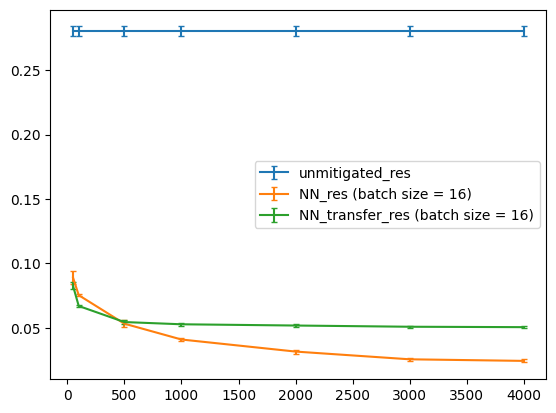

In [20]:
plt.errorbar(train_size, mean_unmiti, yerr = std_unmiti, capsize = 2, label = 'unmitigated_res')
plt.errorbar(train_size, mean_NN, yerr = std_NN, capsize = 2, label = 'NN_res (batch size = 16)')
plt.errorbar(train_size, mean_NN_transfer, yerr = std_NN_transfer, capsize = 2, label = 'NN_transfer_res (batch size = 16)')
plt.legend()